# Testing bootstrapped ensemble test-set filter on preproject feature-set

In [2]:
import numpy as np
import pandas as pd
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))

sys.path.insert(1, module_path + '/src')
import utility

sys.path.insert(1, module_path + '/src/models')
import bootstrapped_ensemble_cluster_filter as BE_cluster_filter
import helper


from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from time import time
from sktime.utils.data_io import load_from_tsfile_to_dataframe
from sktime.utils.data_processing import from_nested_to_2d_array

import pprint
import pickle
from time import time

figure_path = module_path + '/figures/'

# Load data, and select features

In [3]:
X_train, y_train = load_from_tsfile_to_dataframe(module_path + '/features/extracted_features_ts_files/lungsound_MiniROCKET_TRAIN.ts')

X_test, y_test = load_from_tsfile_to_dataframe(module_path + '/features/extracted_features_ts_files/lungsound_MiniROCKET_TEST.ts')

In [4]:
from sklearn.model_selection import train_test_split

X_train = from_nested_to_2d_array(X_train)
X_test = from_nested_to_2d_array(X_test)

y_test = y_test.astype(int)
y_train = y_train.astype(int)

X_train.columns = np.arange(len(X_train.columns))
X_test.columns = np.arange(len(X_test.columns))

X_train.head(10)


y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

k = 200
select = SelectKBest(chi2, k=k)
X_train_s = select.fit(X_train, y_train)
indices = select.get_support(indices = True)
X_test = X_test[indices]

X_train = X_train[indices]

X_val = X_val[indices]

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


k_range = list(range(1,8))
cluster_range = list(range(10,15))
thresh_range = [8]

weight_options = ["uniform", "distance"]
grid = dict(n_neighbors = k_range, weights = weight_options)

clf = KNeighborsClassifier()

clf_dict = {'knnOptimal': KNeighborsClassifier(n_neighbors=6), 'nb': GaussianNB()}

grid_dict = {
    'knnOptimal': grid
}
start = time()
param_dict = BE_cluster_filter.hyperparam_search_accuracy(X_train, y_train, X_val, y_val,
                                   clf_dict,
                                   clusters_list = cluster_range,
                                  thresh_list = thresh_range)
print(f'Time used: {time() - start}')
pprint.pprint(param_dict)

Time used: 262.92533779144287
{'knnOptimal': {'custers': 13,
                'keep clusters': array([ 0,  4,  5,  6,  7, 10, 11, 12]),
                'threshold': 8},
 'nb': {'custers': 11,
        'keep clusters': array([ 0,  1,  3,  4,  6,  7, 10]),
        'threshold': 8}}


## Testing with the optimal hyperparameters

In [9]:
_, indices = BE_cluster_filter.bootstrapped_ensemble_cluster_filter(X_train, y_train, X_test, y_test, clf_dict,
                                     param_dict = param_dict)

auc_init, auc_filtered, _ = helper.get_auc_scores(X_test, y_test, clf_dict, indices)
print('AUC score for the initial classifiers: ')
pprint.pprint(auc_init)
print('AUC score for the filtered dataset: ')
pprint.pprint(auc_filtered)

AUC score for the initial classifiers: 
{'knnOptimal': 0.5926158725860885, 'nb': 0.6078109034177538}
AUC score for the filtered dataset: 
{'knnOptimal': 0.6021538238702201, 'nb': 0.622891998564765}


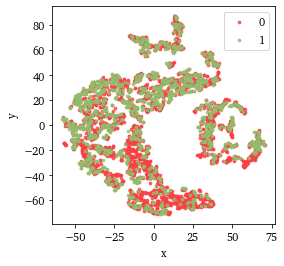

In [12]:
dim_red = 'tsne'
X_test_2d = helper.get_dim_reduced_X(X_train, dim_red, X_train, y_train)

f = helper.scatterplot_with_colors(X_test_2d, y_train.values)
f.savefig(figure_path + f'scatter_plots_2d_data/lung_sound_data_{dim_red}_minirocket.pdf', bbox_inches='tight')

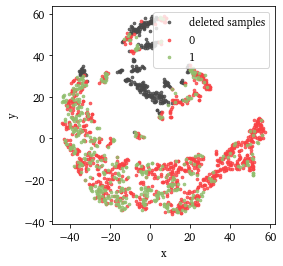

In [15]:
dim_red = 'tsne'
X_test_2d = helper.get_dim_reduced_X(X_test, dim_red, X_train, y_train)
mask=np.full(len(y_test),True,dtype=bool)
mask[indices['nb']]=False

new_y_test = y_test.copy()
new_y_test.iloc[mask] = -1

f = helper.scatterplot_with_colors(X_test_2d, new_y_test.values)
f.savefig(figure_path + f'scatter_plots_2d_data/lung_sound_data_cluster_filtered_{dim_red}_minirocket.pdf', bbox_inches='tight')

In [16]:
ampl_list = [5, 10, 15, 20, 25, 30, 35, 40]
filtered = {}
init = {}
removed_data = {}
for ampl in ampl_list:
    new_X, n_idx= helper.add_noise_dataset(X_test, ampl, 4)
    
    _, indices = BE_cluster_filter.bootstrapped_ensemble_cluster_filter(X_train,y_train, new_X, y_test, clf_dict, param_dict = param_dict)

    auc_init, auc_filtered, rm_data = helper.get_auc_scores(new_X, y_test, clf_dict, indices)
    
    filtered[ampl] = auc_filtered
    init[ampl] = auc_init
    removed_data[ampl] = rm_data
    

a_file = open(module_path + '/src/models/dictionaries_filter_results/lung_data_cluster_amplitude_minirocket.pkl', 'wb')
pickle.dump(init,a_file)
pickle.dump(filtered, a_file)
pickle.dump(removed_data, a_file)
a_file.close()

In [17]:
amount_list = [12, 10, 7, 5, 4, 3, 2] # Is invertly large --> 3 means more noise is added than 4
filtered = {}
init = {}
removed_data = {}

for am in amount_list:
    new_X, n_idx= helper.add_noise_dataset(X_test, 15, am)
    
    
    _, indices = BE_cluster_filter.bootstrapped_ensemble_cluster_filter(X_train,y_train, new_X, y_test, clf_dict, param_dict = param_dict)

    auc_init, auc_filtered , rm_data= helper.get_auc_scores(new_X, y_test, clf_dict, indices)
    
    filtered[am] = auc_filtered
    init[am] = auc_init
    removed_data[am] = rm_data

    
a_file = open(module_path + '/src/models/dictionaries_filter_results/lung_data_cluster_amount_minirocket.pkl', 'wb')
pickle.dump(init,a_file)
pickle.dump(filtered, a_file)
pickle.dump(removed_data, a_file)
a_file.close()